# 2019320016 차주한

### Load dataset

In [1]:
import pandas as pd

data = pd.read_csv("./data/train.csv")
del data["id"]

print(len(data))
print(data[:5])

data.drop_duplicates(subset=["mail"], inplace=True)
print(len(data))

3620
   label                                               mail
0      0  Subject: update on prc process\r\nplease read ...
1      1  Subject: via - gra pro will get you hard consu...
2      0  Subject: re : southern\r\ndarren :\r\ni zeroed...
3      0  Subject: hpl nom for sept . 22 , 2000\r\n( see...
4      1  Subject: perform your best in bed\r\ngeneric c...
3528


### Split train and validation set

In [3]:
from sklearn.model_selection import train_test_split

X = data["mail"]
y = data["label"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print("train data")
print(f"non spam: {round(y_train.value_counts()[0]/len(y_train) * 100, 3)}%")
print(f"spam: {round(y_train.value_counts()[1]/len(y_train) * 100, 3)}%")

print()

print("validation data")
print(f"non spam: {round(y_val.value_counts()[0]/len(y_val) * 100, 3)}%")
print(f"non spam: {round(y_val.value_counts()[1]/len(y_val) * 100, 3)}%")

train data
non spam: 71.297%
spam: 28.703%

validation data
non spam: 71.246%
non spam: 28.754%


### Tokenize & encode words

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)

print(X_train_encoded[0])
print(X_train_encoded[1])
print(X_train_encoded[2])

vocab_size = len(tokenizer.word_index) + 1

max_len = max(len(line) for line in X_train_encoded)
X_train_padded = pad_sequences(X_train_encoded, maxlen=max_len)
print(X_train_padded.shape)

[9, 2416, 6469, 1455, 2262, 133, 4469, 1, 70, 187, 51, 8, 4153, 18, 28, 28, 164, 52, 185, 17, 167, 948, 518, 90, 147, 391, 43, 48, 6, 151, 1, 2723, 2519, 17703, 1, 17704, 5770, 3886, 5251, 54, 121, 1561, 2416, 1973, 11637, 1, 5771, 1456, 394, 167, 263, 3138, 121, 338, 1561, 2416, 1973, 11637, 1, 11638, 1456, 394, 167, 1008, 148, 3665, 17705, 5770, 3886, 5251, 69, 138, 1561, 2416, 1393, 5772, 1, 134, 148, 3887, 148, 31, 1456, 80, 191, 1561, 2416, 1973, 5772, 1, 8918, 148, 7414, 148, 68, 148, 121, 338, 1561, 2416, 1973, 5772, 1, 7415, 148, 11639, 148, 54, 148, 17706, 5770, 3886, 5251, 121, 338, 1561, 2416, 1973, 5772, 1, 17707, 148, 11640, 148, 247, 2724, 581, 1291, 1561, 2416, 1973, 5772, 1, 8919, 148, 17708, 148, 247, 2724, 338, 874, 1561, 2416, 1973, 5772, 1, 11639, 148, 11640, 148, 247, 2724, 17709, 5770, 3886, 5251, 581, 1291, 1561, 6470, 1973, 5252, 148, 5773, 148, 949, 3138, 312, 227, 1561, 2416, 1973, 2725, 148, 17710, 148, 1291, 148, 17711, 5770, 3886, 5251, 227, 762, 1561, 6470

### Train RNN model using keras

In [5]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
history = model.fit(X_train_padded, y_train, epochs=4, batch_size=128, validation_split=0.2)

Epoch 1/4
18/18 [==============================] - 45s 2s/step - loss: 0.5342 - acc: 0.7306 - val_loss: 0.4661 - val_acc: 0.8018

### Test on validation set

In [6]:
X_val_encoded = tokenizer.texts_to_sequences(X_val)
X_val_padded = pad_sequences(X_val_encoded, maxlen=max_len)
print(model.evaluate(X_val_padded, y_val)[1])

23/23 [==============================] - 6s 237ms/step - loss: 0.1712 - acc: 0.9433

### Visualization

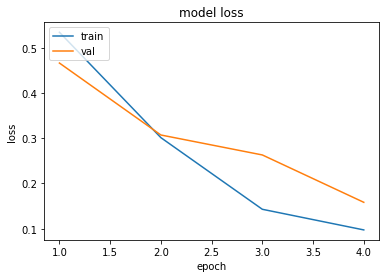

In [7]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history["acc"]) + 1)
plt.plot(epochs, history.history["loss"])
plt.plot(epochs, history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

### Predict on test set

In [10]:
import csv
import numpy as np

test_data = pd.read_csv("./data/test.csv")
del test_data["id"]

print(len(test_data))
print(test_data[:5])

X_test = test_data["mail"]

X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_len)

res = np.where(model.predict(X_test_padded) > 0.5, 1, 0)

print(res)

f = open("result_rnn.csv", "w", newline="")
wr = csv.writer(f)
wr.writerow(["id", "label"])

id = 0
for i in res:
    wr.writerow([id, i[0]])
    id += 1

f.close()

1551
                                                mail
0  Subject: re : coastal ctr # 96008903 meter 098...
1  Subject: re :\r\nfyi\r\n- - - - - - - - - - - ...
2  Subject: hpl nomination changes for july 25 an...
3  Subject: new stack manager\r\nthere is a new v...
4  Subject: deletion of your enrononline user id\...
[[0]
 [0]
 [0]
 ...
 [1]
 [0]
 [0]]
